# AML flow cytometry analysis

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from fcvae_dataset import load_data
from fcvae_model import VAE, Encoder, Decoder, Classifier
from fcvae_trainer import fcTrainer
from fcvae_plot import CellPlotter2D, plot_joint_aml, plot_shared_markers_aml, plot_imputed_values_set
from umap import UMAP
import flowkit as fk
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch version:", torch.__version__)
print("Device:", device)

Torch version: 1.2.0
Device: cpu


## 1. Load data

In [2]:
filepath1 = "/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/data_files1/"

batch_size = 256         # number of data points in each batch
n_epochs = 30           # times to run the model on complete data
input_dim = 7     # size of each input
hidden_dim = 128        # hidden dimension
latent_dim = 6        # latent vector dimension
lr = 1e-3              # learning rate
n_head = 2
n_shared = 3
missing = 4

datasets = load_data(filepath1)

input_dim_list = []
output_dim_list = []
train_iterators = []
test_iterators = []
train_cells = 0
test_cells = 0
for tube in datasets:
    input_dim_list.append(len(tube[0].columns))
    output_dim_list.append(len(tube[0].columns)+missing)
    train_iterators.append(tube[3])
    test_iterators.append(tube[4])
    train_cells += tube[1].nb_cells
    test_cells += tube[2].nb_cells

N_train = int(train_cells/n_head)
N_test = int(test_cells/n_head)
print('Training set size:', N_train)
print('Test set size:', N_test)

Training set size: 27000
Test set size: 3000


## 2. Create a model

In [3]:
# Encoder
encoder = Encoder(n_head, input_dim_list, hidden_dim, latent_dim)

# Decoder
decoder = Decoder(latent_dim, hidden_dim, output_dim_list, n_head)

# VAE
model = VAE(encoder, decoder).to(device)

# Discriminator
discriminator = Classifier(latent_dim, hidden_dim, n_head) 

print("n_tubes:", n_head)
print("n_shared:", n_shared)
print("n_other:", missing)
print("output_dim:", output_dim_list[0])
print("encoder_dims:", input_dim_list)

n_tubes: 2
n_shared: 3
n_other: 4
output_dim: 11
encoder_dims: [7, 7]


## 3. Train the model

In [4]:
# Create trainer
trainer = fcTrainer(
            model,
            discriminator,
            train_loaders = train_iterators,
            test_loaders = test_iterators,
            N_train = N_train,
            N_test = N_test,
            dloss_weight = 60,
            device = device,
            n_epochs = n_epochs,
            print_frequency = 1,
            optimizer_kwargs = dict(lr = lr)
)

12/05/2020 20:38:34 [INFO]: Creating a trainer on device `cpu`


In [5]:
# Run training
trainer.train()

12/05/2020 20:38:34 [INFO]: TRAINING STARTED (n_epochs = 30).
12/05/2020 20:38:50 [INFO]: Epoch: 00, VAE loss: (62.10432, 16.96138), Discriminator loss: (0.73998, 1.14185)
12/05/2020 20:39:05 [INFO]: Epoch: 01, VAE loss: (25.25408, 15.23013), Discriminator loss: (0.71089, 1.1577)
12/05/2020 20:39:20 [INFO]: Epoch: 02, VAE loss: (22.33372, 12.63201), Discriminator loss: (0.62724, 1.10329)
12/05/2020 20:39:36 [INFO]: Epoch: 03, VAE loss: (20.11574, 11.02567), Discriminator loss: (0.64783, 1.11036)
12/05/2020 20:39:51 [INFO]: Epoch: 04, VAE loss: (19.29504, 11.61545), Discriminator loss: (0.73554, 1.17476)
12/05/2020 20:40:06 [INFO]: Epoch: 05, VAE loss: (18.71916, 10.116), Discriminator loss: (0.78042, 1.20588)
12/05/2020 20:40:21 [INFO]: Epoch: 06, VAE loss: (17.90497, 9.13525), Discriminator loss: (0.82032, 1.17563)
12/05/2020 20:40:36 [INFO]: Epoch: 07, VAE loss: (17.06422, 11.26413), Discriminator loss: (0.86148, 1.17867)
12/05/2020 20:40:51 [INFO]: Epoch: 08, VAE loss: (16.83552, 8.

## 4. Visualization

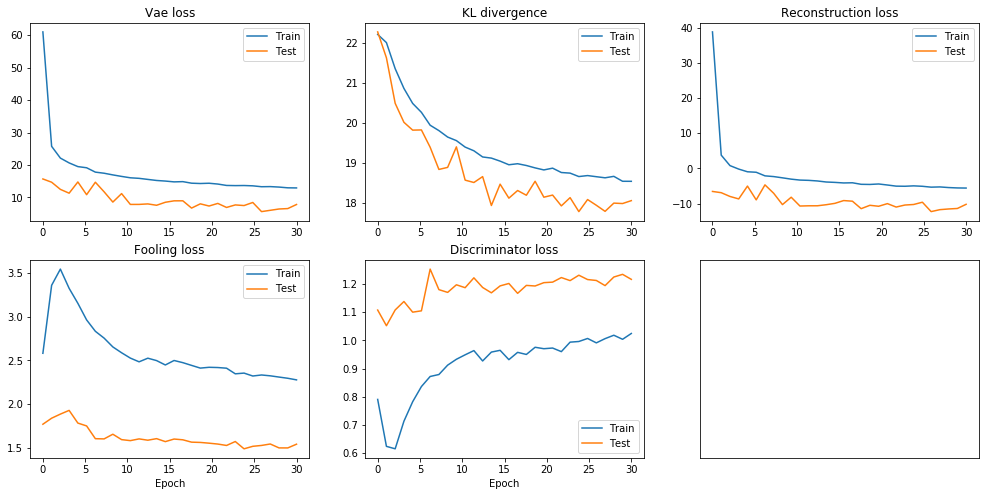

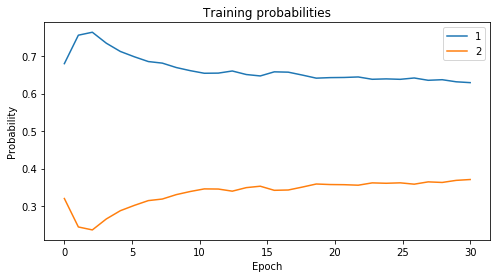

In [13]:
trainer.plot()
trainer.plot_probs()
# no test curves?

/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.

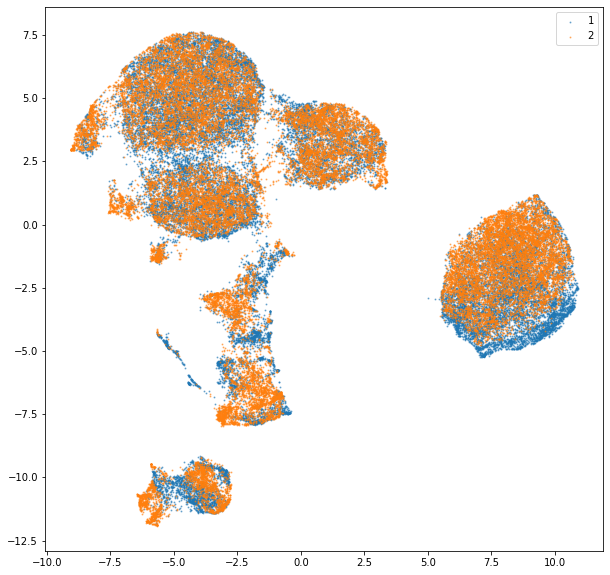

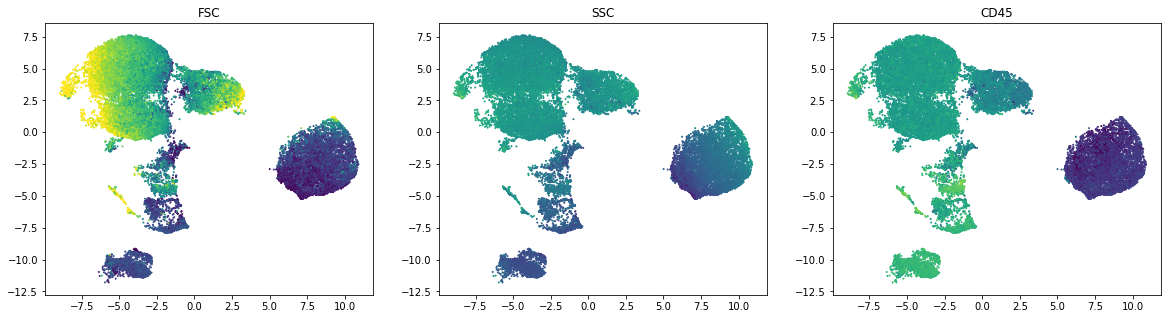

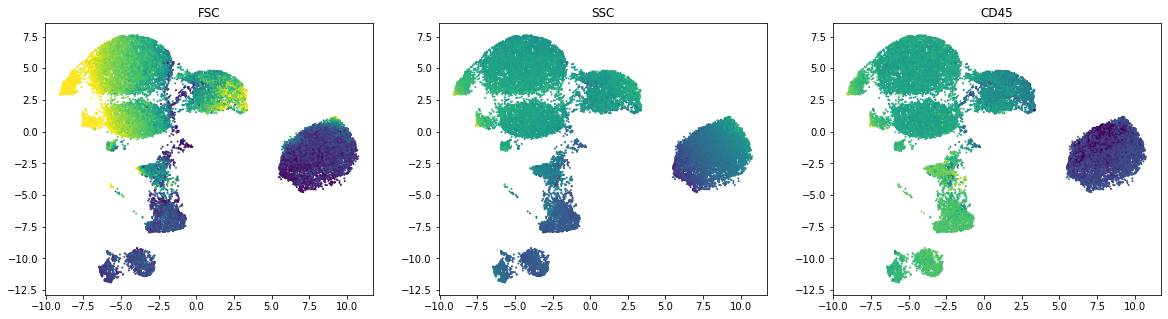

In [6]:
latents = []

trainer.vae.eval()
for i in range(n_head):
    data = Variable(torch.from_numpy(datasets[i][0].to_numpy()), requires_grad=False)
    latents.append(model.get_z(data.float(), i).data.numpy())
latent2d = UMAP().fit_transform(np.concatenate(latents))

plot_joint_aml(trainer, latent2d, latents, save_name='/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/Results/final_joint_aml.jpg)
plot_shared_markers_aml(trainer, latent2d, latents, datasets)

## 5. Imputation

In [14]:
# marker names 
files = glob.glob(filepath1 + "*.txt")
titles = []
for i in range(len(files)):
    fcs = files[i][-8:-4]
    fcs_path = '/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/Data/AML/FCS/'+fcs+'.FCS'
    sample = fk.Sample(fcs_path, subsample_count=None)
    features = sample.pns_labels[2:7]
    features.pop(2)
    titles.append(features)
print(titles) 

# visualize one set of imputed values
#plot_imputed_values(trainer, latent2d, latents, datasets, titles) # for 2 tubes only
tube_id = 1
plot_imputed_values_set(trainer, tube_id, latent2d, latents, datasets, titles[tube_id])

/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/flowio/flowdata.py:275: UserWarning: text in segment does not start and end with delimiter
  warn("text in segment does not start and end with delimiter")


[['Kappa-FITC', 'Lambda-PE', 'CD19-PC5', 'CD20-PC7'], ['CD7-FITC', 'CD4-PE', 'CD8-PC5', 'CD2-PC7'], ['Kappa-FITC', 'Lambda-PE', 'CD19-PC5', 'CD20-PC7'], ['CD15-FITC', 'CD13-PE', 'CD16-PC5', 'CD56-PC7'], ['HLA-DR-FITC', 'CD117-PE', 'CD34-PC5', 'CD38-PC7'], ['HLA-DR-FITC', 'CD117-PE', 'CD34-PC5', 'CD38-PC7'], ['CD15-FITC', 'CD13-PE', 'CD16-PC5', 'CD56-PC7'], ['CD7-FITC', 'CD4-PE', 'CD8-PC5', 'CD2-PC7'], ['CD14-FITC', 'CD11c-PE', 'CD64-PC5', 'CD33-PC7'], ['CD14-FITC', 'CD11c-PE', 'CD64-PC5', 'CD33-PC7'], ['CD5-FITC', 'CD19-PE', 'CD3-PC5', 'CD10-PC7'], ['CD5-FITC', 'CD19-PE', 'CD3-PC5', 'CD10-PC7']]


IndexError: list index out of range

## 6. Validation metrics

In [6]:
def validation_accuracy(model, discriminator, test_iterators):
    model.eval()
    discriminator.eval()
    probs = []
    for tensors in test_iterators:
        ps = []
        for head_id, batch in enumerate(tensors):
            z = model.get_z(batch.float(), head_id)
            p = discriminator.classify(z)
            p = p.cpu().detach().numpy()
            ps.append(p)
        #pr = torch.cat(ps).cpu().detach().numpy()
        #print(pr.shape)
        probs.append(ps)
    return probs

def validation_loss(test_iterators, model, input_dim_list):
    # set the evaluation mode
    model.eval()
    n_head = len(input_dim_list)
    # test loss for the data
    test_losses = []
    
    for tensors in test_iterators:
        for head_id, x in enumerate(tensors): 
            # reshape the data
            x = x.view(-1, input_dim_list[head_id]) 
            x = x.float()
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x, head_id)

            loss, recs, kls = model.loss(x_sample, x, z_mu, z_var, head_id)
            test_losses.append(loss)
    sum_loss = torch.stack(test_losses).sum()

    return sum_loss

[(0, 2, 32), (0, 2, 64), (0, 2, 128), (0, 4, 32), (0, 4, 64), (0, 4, 128), (0, 6, 32), (0, 6, 64), (0, 6, 128), (20, 2, 32), (20, 2, 64), (20, 2, 128), (20, 4, 32), (20, 4, 64), (20, 4, 128), (20, 6, 32), (20, 6, 64), (20, 6, 128), (40, 2, 32), (40, 2, 64), (40, 2, 128), (40, 4, 32), (40, 4, 64), (40, 4, 128), (40, 6, 32), (40, 6, 64), (40, 6, 128), (60, 2, 32), (60, 2, 64), (60, 2, 128), (60, 4, 32), (60, 4, 64), (60, 4, 128), (60, 6, 32), (60, 6, 64), (60, 6, 128), (80, 2, 32), (80, 2, 64), (80, 2, 128), (80, 4, 32), (80, 4, 64), (80, 4, 128), (80, 6, 32), (80, 6, 64), (80, 6, 128), (100, 2, 32), (100, 2, 64), (100, 2, 128), (100, 4, 32), (100, 4, 64), (100, 4, 128), (100, 6, 32), (100, 6, 64), (100, 6, 128), (120, 2, 32), (120, 2, 64), (120, 2, 128), (120, 4, 32), (120, 4, 64), (120, 4, 128), (120, 6, 32), (120, 6, 64), (120, 6, 128), (140, 2, 32), (140, 2, 64), (140, 2, 128), (140, 4, 32), (140, 4, 64), (140, 4, 128), (140, 6, 32), (140, 6, 64), (140, 6, 128)]
[[0.16341922 0.163019

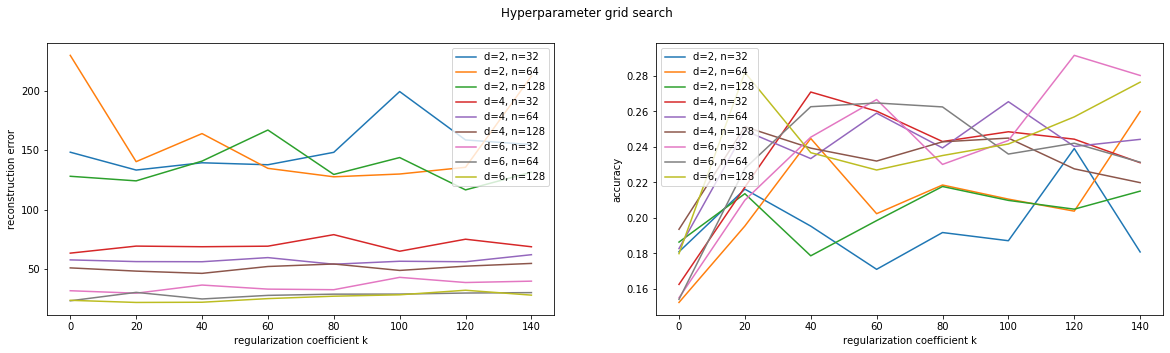

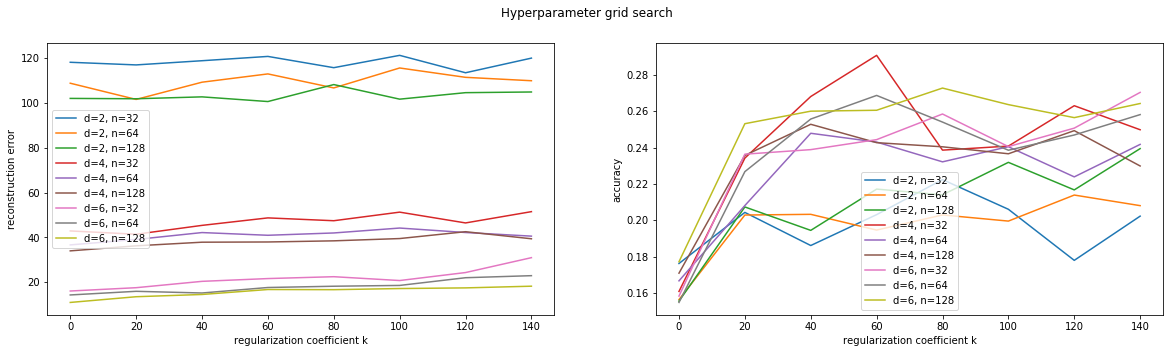

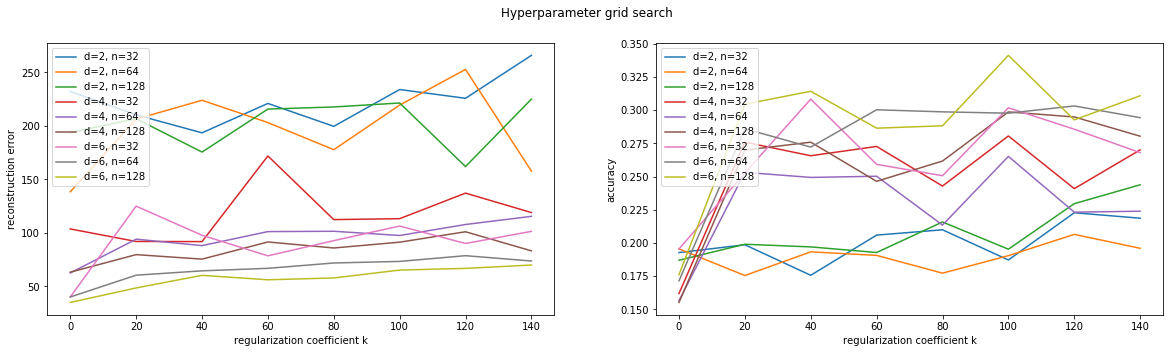

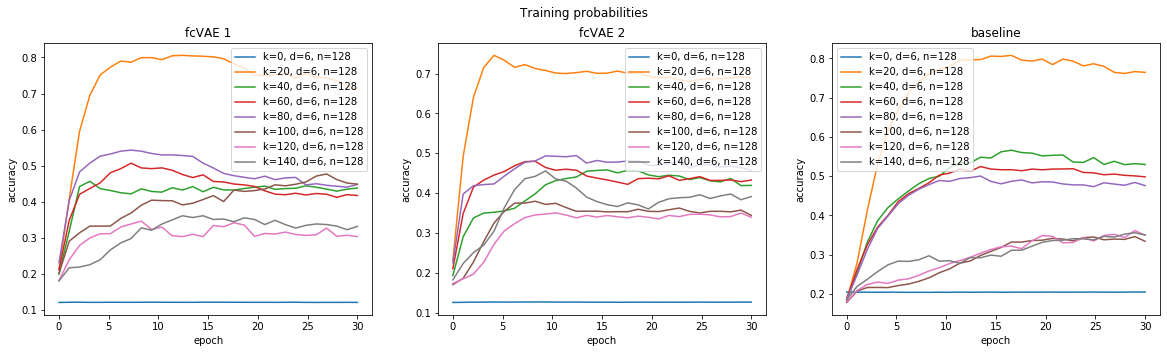

In [9]:
import itertools
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

ks = np.arange(0,150,20)
params = [ks, [2,4,6], [32,64,128]]
params = list(itertools.product(*params))
print((params))

val1 = pd.read_csv('/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/validation_metrics_true.csv', delimiter = ',').to_numpy()
val2 = pd.read_csv('/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/validation_metrics2_true.csv', delimiter = ',').to_numpy()
val_bl = pd.read_csv('/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/validation_metrics_bl_true.csv', delimiter = ',').to_numpy()

vals = [val1, val2, val_bl]
for k,val in enumerate(vals):
    fig = plt.figure(figsize=(20,5))
    fig.suptitle("Hyperparameter grid search")
    titles = ["reconstruction error", "accuracy"]
    for i in range(2):
        x = ks
        y = [elem[i] for elem in val]
        plt.subplot(1,2,i+1)
        for j in range(9):
            label = "d={}, n={}".format(params[j][1], params[j][2]) 
            plt.plot(x, y[j::9], label=label)
        plt.xlabel("regularization coefficient k")
        plt.ylabel(titles[i])
        plt.legend()
    file = "/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/Results/validation{}_true.jpg".format(k+1)
    plt.savefig(file, dpi=300)
    
p1 = pd.read_csv('/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/training_probs_grid_.csv', delimiter = ',').to_numpy()
p2 = pd.read_csv('/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/training_probs_grid2.csv', delimiter = ',').to_numpy()
p_bl = pd.read_csv('/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/training_probs_grid_bl.csv', delimiter = ',').to_numpy()
print(p1)

vals = [p1[7::8], p2[7::8], p_bl[7::8]]
fig = plt.figure(figsize=(20,5))
fig.suptitle("Training probabilities")
titles = ["fcVAE 1", "fcVAE 2", "baseline"]
for k,val in enumerate(vals):
    #fig.suptitle("Hyperparameter grid search")
    #titles = ["reconstruction error", "accuracy"]
    #for i in range(2):
    plt.subplot(1,3,k+1)
    t=1
    for j in range(8):
        x = np.linspace(0,30,30)#ks[8::9]
        y = val[j]
        label = "k={}, d={}, n={}".format(params[8*t+j][0],params[8*t+j][1], params[8*t+j][2]) 
        plt.plot(x, y, label=label)
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.title(titles[k])
        plt.legend()
        if t <= 7:
            t+=1
file = "/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/Results/validation_train_probs_aml.jpg"
plt.savefig(file, dpi=300)

In [7]:
# model selection with test data
import pandas as pd
from torch.utils.data import DataLoader, Dataset

def load_test_data(filepath, test_size: float = 0.1, batch_size: int = 256, validation: bool = False):
    files = glob.glob(filepath + "test_" + "*.txt")
    all_datasets = []
    for i, file in enumerate(files): #order of markers, missing cloumns
        fc = pd.read_csv(file, delimiter = ',')
        fc.iloc[:,[1,2,3,4,5,6]] = np.log(fc.iloc[:,[1,2,3,4,5,6]]) 
        std_dev = np.std(fc)
        mean = np.mean(fc)
        fc = (fc - mean) / std_dev
        fc_sub = fc.iloc[:,[0,1,4, 2,3,5,6]]
        
        all_data = fcm_data(fc_sub)
        whole_dataset = DataLoader(all_data, batch_size=batch_size)
        all_datasets.append([fc_sub, whole_dataset])   

    return all_datasets

class fcm_data(Dataset):
    
    def __init__(self, data):
        self.data = data
        self.marker_names = np.asarray(data.columns, dtype=str)
        self.cell_names = np.asarray(data.index.values, dtype=str)
        self.data = data.values
        
    def __len__(self):
        return len(self.cell_names)
    
    def __getitem__(self, index):
        return self.data[index,:]
    
    @property 
    def nb_cells(self) -> int:
        return self.data.shape[0]
    
    @property
    def nb_markers(self) -> int:
        return self.data.shape[1]

datasets = load_test_data(filepath1)

test_iterators = []
for tube in datasets:
    test_iterators.append(tube[1])

runs = 5
accuracies = []
val_losses = []
#for i in range(runs):
#trainer.train()
acc = validation_accuracy(model, discriminator, zip(*test_iterators))
print(len(acc[0]))
acc = [item for sublist in acc for item in sublist]
acc = [(acc[i::n_head]) for i in range(n_head)]
print((acc[0][11].shape))
correct = 0
for i, a in enumerate(acc):
    conc = [item for sublist in a for item in sublist]
    conc = np.array(conc)
    for r in range(len(conc)):
        if conc[r,i] == max(conc[r,:]):
            correct += 1
#acc = [item for sublist in acc for item in sublist]
#probs1 = acc[::n_head]
#print(len(probs1))
#for i in probs1[:N_test]:
#    if i > 1/n_head:
#        correct += 1
#for i in probs1[N_test:]:
#    if i < 1/n_head:
#        correct += 1

accuracy = correct/(N_test*n_head)
#accuracies.append(accuracy)
val_loss = validation_loss(zip(*test_iterators), model, input_dim_list)/N_test
#val_losses.append(val_loss)
print(accuracy)
print(val_loss)

#print(np.mean(accuracies))
#print(torch.mean(torch.stack(val_losses)))


6
(184, 6)
0.25922222222222224
tensor(102.0120, grad_fn=<DivBackward0>)


## 7. Simulated data

In [1]:
from fcvae_simulate import simulate, plot_latent, plot_x
import numpy as np

# Simulate data
N_cells_per_cluster = 200
N_clusters = 5
x, z, labs = simulate(N_cells_per_cluster, N_clusters)

# Visualize full data
plot_latent(z, labs)
plot_x(x, z)

# After this, one could create multi-tube data from the full x by splitting the cells between tubes
n_cells_total = x.shape[0]
indices = np.random.permutation(n_cells_total)
n_cells_tube1 = 500
i1 = indices[0:n_cells_tube1]
i2 = indices[n_cells_tube1:n_cells_total]
x_tube1 = x[i1, :]
x_tube2 = x[i2, :]

# Censor some dimensions of x in different tubes (8 first shared)
x_tube1 = x_tube1[:, [0, 1, 2, 3, 4, 5, 6, 7,     8,  9, 10, 11]]
x_tube2 = x_tube2[:, [0, 1, 2, 3, 4, 5, 6, 7,    12, 13, 14, 15]]
print(x_tube1.shape)
print(x_tube2.shape)

<Figure size 600x600 with 1 Axes>

<Figure size 1000x800 with 32 Axes>

(500, 12)
(500, 12)
